In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [14]:
orders = pd.read_csv('C:/Users/naman/Downloads/archive (1)/olist_orders_dataset.csv')
payments = pd.read_csv('C:/Users/naman/Downloads/archive (1)/olist_order_payments_dataset.csv')
reviews = pd.read_csv('C:/Users/naman/Downloads/archive (1)/olist_order_reviews_dataset.csv')
order_items = pd.read_csv('C:/Users/naman/Downloads/archive (1)/olist_order_items_dataset.csv')
customers = pd.read_csv('C:/Users/naman/Downloads/archive (1)/olist_customers_dataset.csv')
products = pd.read_csv('C:/Users/naman/Downloads/archive (1)/olist_products_dataset.csv')
sellers = pd.read_csv('C:/Users/naman/Downloads/archive (1)/olist_sellers_dataset.csv')
geo = pd.read_csv('C:/Users/naman/Downloads/archive (1)/olist_geolocation_dataset.csv')


In [15]:
# Merge datasets on order_id
combined_df = orders.merge(order_items, on='order_id', how='left')
combined_df = combined_df.merge(payments, on='order_id', how='left')
combined_df = combined_df.merge(reviews, on='order_id', how='left')
combined_df = combined_df.merge(customers, on='customer_id', how='left')

In [17]:
# Convert date columns to datetime
date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 
             'order_estimated_delivery_date', 'order_approved_at']
for col in date_cols:
    combined_df[col] = pd.to_datetime(combined_df[col])

# Create delivery_delay feature (in days)
combined_df['delivery_delay'] = (
    combined_df['order_delivered_customer_date'] - 
    combined_df['order_estimated_delivery_date']
).dt.days

# Binary indicator: 1 if delayed, 0 otherwise
combined_df['is_delayed'] = (combined_df['delivery_delay'] > 0).astype(int)

# Create refund/cancellation flag (target variable)
combined_df['refund_flag'] = combined_df['order_status'].isin(
    ['canceled', 'unavailable', 'refunded']
).astype(int)

# Calculate order processing time
combined_df['processing_time'] = (
    combined_df['order_approved_at'] - 
    combined_df['order_purchase_timestamp']
).dt.total_seconds() / 3600  # in hours

# Price-related features
combined_df['total_order_value'] = combined_df['price'] + combined_df['freight_value']
combined_df['freight_ratio'] = combined_df['freight_value'] / combined_df['total_order_value']

# Review score (indicator of satisfaction)
combined_df['review_score'] = combined_df['review_score'].fillna(combined_df['review_score'].median())



Overall Cancellation Rate: 1.18%


KeyError: 'product_category_name'

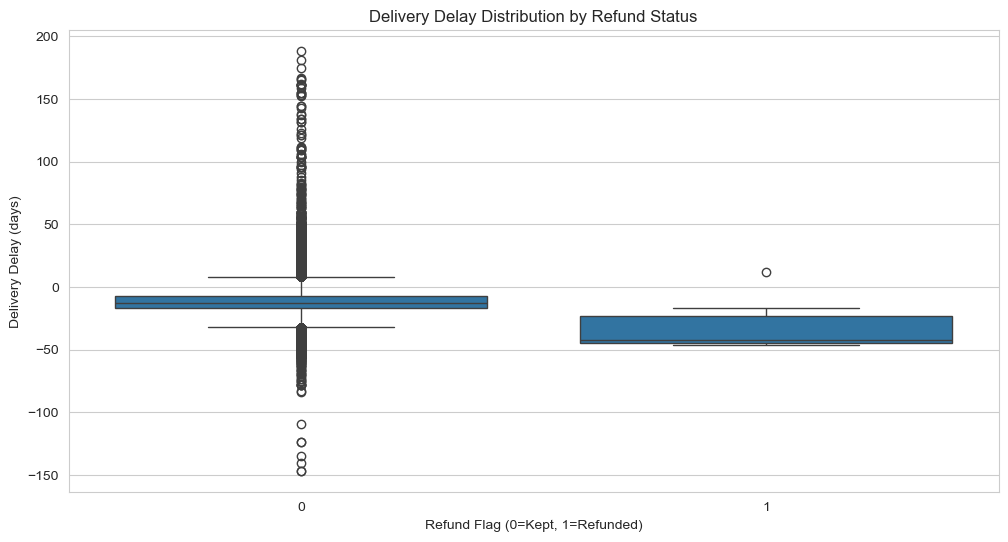

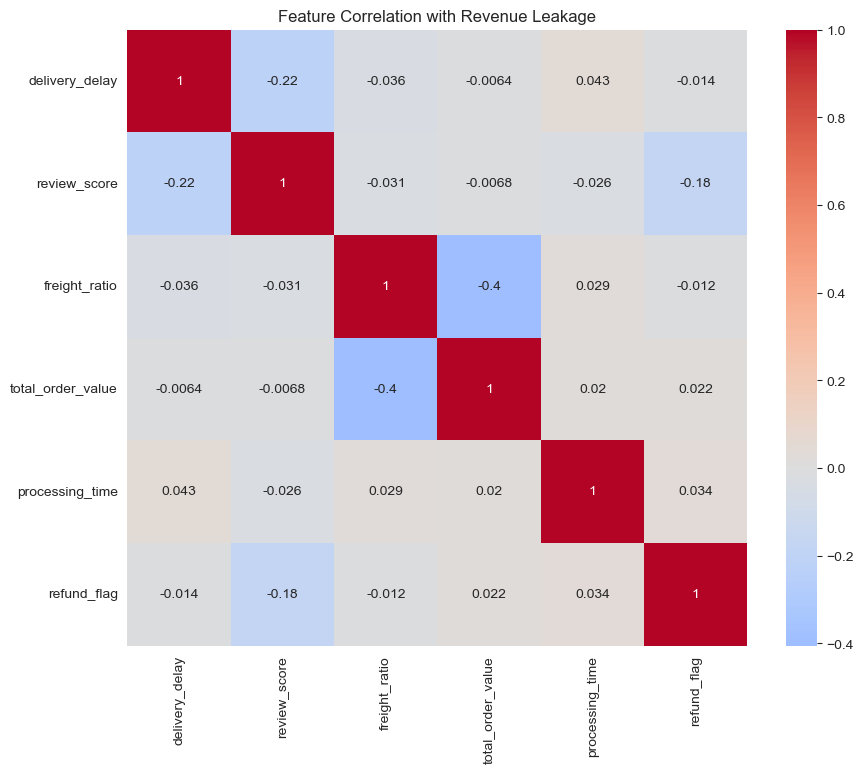

In [18]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Cancellation rate analysis
cancellation_rate = combined_df['refund_flag'].value_counts(normalize=True)
print(f"Overall Cancellation Rate: {cancellation_rate[1]*100:.2f}%")

# 2. Delivery delay impact on refunds
plt.figure()
sns.boxplot(data=combined_df, x='refund_flag', y='delivery_delay')
plt.title('Delivery Delay Distribution by Refund Status')
plt.xlabel('Refund Flag (0=Kept, 1=Refunded)')
plt.ylabel('Delivery Delay (days)')
plt.savefig('delivery_delay_refunds.png', dpi=300, bbox_inches='tight')

# 3. Correlation heatmap
correlation_features = ['delivery_delay', 'review_score', 'freight_ratio', 
                        'total_order_value', 'processing_time', 'refund_flag']
plt.figure(figsize=(10, 8))
sns.heatmap(combined_df[correlation_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with Revenue Leakage')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')

# 4. Refund patterns by product category
category_refunds = combined_df.groupby('product_category_name')['refund_flag'].mean().sort_values(ascending=False).head(10)
plt.figure()
category_refunds.plot(kind='barh')
plt.title('Top 10 Product Categories by Refund Rate')
plt.xlabel('Refund Rate')
plt.savefig('category_refunds.png', dpi=300, bbox_inches='tight')

# 5. Seasonal analysis
combined_df['order_month'] = combined_df['order_purchase_timestamp'].dt.to_period('M')
monthly_refunds = combined_df.groupby('order_month')['refund_flag'].mean()
plt.figure()
monthly_refunds.plot()
plt.title('Monthly Refund Rate Trends')
plt.ylabel('Refund Rate')
plt.xlabel('Month')
plt.savefig('seasonal_refunds.png', dpi=300, bbox_inches='tight')
